# Milestone 3 Assignment - Capstone Project

## Author - Kenji Oman
## Teammates
* Kyle Slyngstad
* Tsun Tsai

### Contributions made
I cleaned/ prepared the weather and daylight data for Milestone 1, while my teammates prepared the Traffic violations data, with the charge title/ subtitles pulled by Kyle.  After merging our individual contributions together (performed by Kyle and myself), I further cleaned/ prepared the features, as documented in Milestone 2 (all efforts post-merging are independent of other teammates).

# <font color="blue">Problem and Key Insight</font>

## Problem & Background
The goal of this project is to predict the type of traffic violations an individual is likely to face in Montgomery County Maryland, given their location, demographics, car type, weather, and amount of daylight.  This could be used to help inform drivers, as they plan their routes, for different things they should watch out for, helping them to modify their driving behavior if necessary.

## Conclusions
* Feature selection provided great improvements to a naive bayes classifier, but didn't affect the other classifiers very much (work comparing all features vs trimmed set of features not shown in this notebook for the other classifiers)
* Ensembl methods performed vastly superior to any other method, perhaps because of the complexity of the data.
* Underrepresented targets (LightLampSignalDefect) are predicted less well than more abundant targets.
* In terms of the buisness problem, race and driver's license state were the only features that survived feature selection (among others such as gender and age).  In terms of the mutual information content with the target variable, race ranked the 6th highest (with some of the higher features correlated with each other).  Sad, but it looks real that there is truly a gender bias to the type of charges an individual will face.

## Next Steps
We observe that with a random forest classifier, we are able to achieve accuracies ~45%.  Although this is much better than all other classifiers, we did not systematically search the hyperparameter space of our different classifiers.  Also, we could train the data on a larger portion of the dataset (given more time for training), and try to balance our classes (either by simulating new data, or by using differnt sampling methods).  Finally, we could further examine how we cleaned up/ engineered our features to try to better capture the information they contain, prior to feature selection.  Then, it is possible that a different set of features would be chosen, better able to inform us of our target charges made.

Additionally, it would be interesting to further investigate which charges race correlates with to perhaps identify race disparities we could pass back to the Montgomery County police force to help improve their training to make the charges given more color-neutral.

# <font color="blue">Data Exploration and Preparation</font>

## Sources
There are 4 primary data sources in use in this project:
* Traffic violations data [from Kaggle](https://www.kaggle.com/rounak041993/traffic-violations-in-maryland-county/version/1)
* Montgomery County weather data [downloaded from a portal from NOAA](https://www.ncdc.noaa.gov/cdo-web/search) (see Milestone 1 notebook for details on query made)
* Derived daylight values, from time, using the [astral](https://astral.readthedocs.io/en/stable/index.html) package.
* Charge Title/ subtitles, derived from various sources online (used to map the "charges" column of the traffic violations data).

In [1]:
# First, load all libraries we need
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Variable to point to the cleaned data
CLEANED_DATA = 'KenjiOman-M03-Capstone-FinalData.csv.gz'

# Now, load the data
df = pd.read_csv(CLEANED_DATA, compression='gzip')

# Add a column for what the target variable translates to, to make reading the reports easier
target_map = ['FailuretoObeyTrafficControlDevices', 'ImproperPlatesRegistration', 'LightLampSignalDefect',
              'Other', 'OtherDefect', 'RulesofRoad_Other', 'Speeding']
df['Charge_key'] = df.Charge.apply(lambda x: target_map[x])
df.head()

,hour,Latitude,daylight,VehicleMake,Longitude,weekday,dayofyear,MinTemp,Precipitation,Race,DL_State,Belts,Commercial_License,Charge,Charge_key
0,-0.427028,-1.466020,0.911732,-2.082039,0.194015,-0.936421,0.623749,0.811205,1.164897,0.981119,-1.773761,-0.18992,-0.174494,0,FailuretoObeyTrafficControlDevices
1,-0.567603,-0.376411,0.911732,-0.187635,1.664142,-0.936421,0.623749,0.811205,1.164897,-1.248176,0.278965,-0.18992,-0.174494,0,FailuretoObeyTrafficControlDevices
2,-1.692202,0.583122,-1.156570,0.210192,-1.298660,-0.936421,0.623749,0.811205,1.164897,0.560264,0.278965,-0.18992,-0.174494,3,Other
3,-1.692202,0.583122,-1.156570,0.210192,-1.298660,-0.936421,0.623749,0.811205,1.164897,0.560264,0.278965,-0.18992,-0.174494,3,Other
4,-1.129903,0.763251,-1.156570,0.210192,1.235791,-0.936421,0.623749,0.811205,1.164897,0.560264,0.278965,-0.18992,-0.174494,0,FailuretoObeyTrafficControlDevices


In [3]:
# Here is the pandas profile report. For reports on the raw data,
# see Milestone 1
pandas_profiling.ProfileReport(df.drop(columns='Charge'))

Number of variables,14
Number of observations,1188112
Total Missing (%),0.0%
Total size in memory,126.9 MiB
Average record size in memory,112.0 B
Numeric,11
Categorical,1
Boolean,2
Date,0
Text (Unique),0
Rejected,0


As we saw in the profile report above (and reproduced below), we've split our target into 7 categories, with the smallest category (LightLampSignalDefect) having a little less than one fourth the number of observations of the largest category (FailuretoObeyTrafficControlDevices)

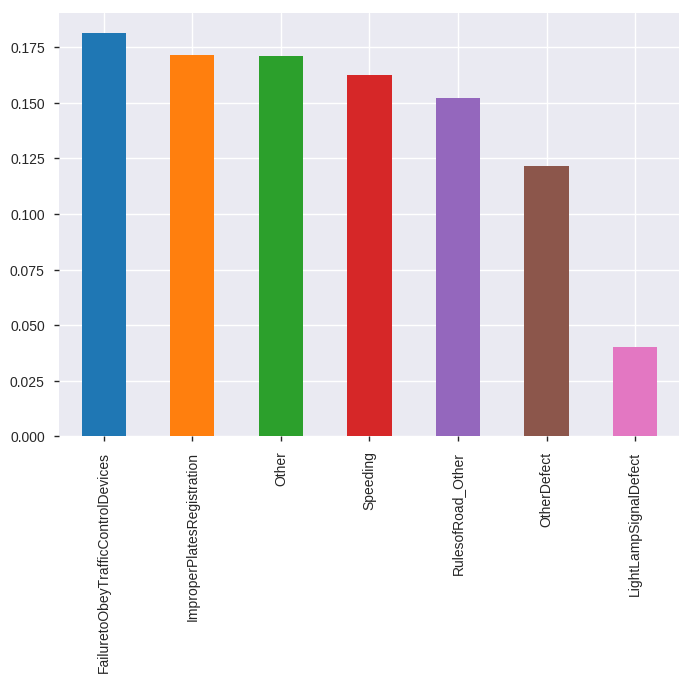

In [4]:
# A visualization of the fraction of observations with each of the
# classification targets.
df.Charge_key.value_counts(normalize=True).plot.bar()
plt.show()

## Data Exploration Summary
We were able to condense our orignal target features down to 7.  However, with LightLampSignalDefect being so disproportionately underrepresented, our models may struggle to correctly identify these observations without some additional work.

# <font color="blue">Feature Engineering and Selection</font>
All our feature engineering/ selection was performed in Milestones 1 and 2, so this doesn't need to be performed here.  Much of the engineering was also a part of the data cleaning process (as previously described). As a summary of key components (after most of the cleaning):

1. Feature Engineering
 1. Charge (our target) was binned from the original list of charges to create 7 logically grouped categories.
 2. Using Target Encoding (capturing how a feature category correlates with the target), we encoded all categorical columns to their respective target encoded values.  Target encoding was chosen to minimize the number of additional features constructed.
 3. Because the range of some features vastly differed from others, we performed standard scaling (z-scaling) on all predictors.

2. Feature Selection
 1. Initially, we only dropped a few features that had clustered close together in correlation clustering
 2. Further feature selection was performed using forward and backward step-wise selection using a Naive Bayes Classifier, selecting the set of features that maximized the prediciton accuracy.

# <font color="blue">Data Models</font>
We have a multi-class classification problem.  Therefore, we will use a few different classifiers for our task:

* Naive Bayes
* Logistic Regression
* SVM Classifier
* Random Forest Classifier

Let's now define and train our respective classifiers.

In [5]:
# First, split our data
train_df, test_df = train_test_split(df, random_state=10, shuffle=True, stratify=df.Charge)

In [6]:
# Define and train a Naive Bayes Classifier
nb_mdl = GaussianNB()
nb_mdl.fit(train_df.drop(columns=['Charge', 'Charge_key']), train_df.Charge)

GaussianNB(priors=None)

In [7]:
# And logistic regression
logistic_mdl = LogisticRegression(random_state=100)
logistic_mdl.fit(train_df.drop(columns=['Charge', 'Charge_key']), train_df.Charge)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# And SVM.  Because it takes so long to train, use only 2% of the training data
svm_mdl = SVC()
trimmed_train_df = train_df.sample(frac=0.02, random_state=10)
svm_mdl.fit(trimmed_train_df.drop(columns=['Charge', 'Charge_key']), trimmed_train_df.Charge)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
# Try a Random Forest
rf_mdl = RandomForestClassifier(n_estimators=20, random_state=10)
rf_mdl.fit(train_df.drop(columns=['Charge', 'Charge_key']), train_df.Charge)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [10]:
# Try Random Forest, but with Entropy instead of Gini for the
# split criterion
rf_mdl_entropy = RandomForestClassifier(n_estimators=20, random_state=10, criterion='entropy')
rf_mdl_entropy.fit(train_df.drop(columns=['Charge', 'Charge_key']), train_df.Charge)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

# <font color="blue">Model Evaluations</font>
Let's calculate the accuracy of each of our models, as well as the confusion matrix.

**In the confusion matrix, we will normalize cells by the actual number of samples per category (by the row count), and multiply by 100 to get percents**.  So, the diagonals will indicate the percent of samples for a given category that were correctly identified (sensitivity, aka recall), and the sum across a row of the off diagonals indicate the false negative rate for that target class.

In [11]:
# Define a function to, given a classifier, make predictions, report on accuracy, and
# draw a confusion matrix
def evaluate_model(clf):
    # First, make some predicitons with the classifier
    predicted = clf.predict(test_df.drop(columns=['Charge', 'Charge_key']))
    
    # Now, calculate the accuracy
    score = accuracy_score(test_df.Charge, predicted)
    
    # Report on the accuracy score
    print('Accuracy Score: {:.2f}%'.format(score * 100))
    
    # Calculate our Confusion Matrix
    cm_out = confusion_matrix(test_df.Charge, predicted)
    cm_out = pd.DataFrame(cm_out, index=target_map, columns=target_map)

    # and draw it
    display(Markdown('### Confusion Matrix'))

    # Plot the confusion matrix
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111)
    temp = pd.DataFrame((100 * cm_out.values/cm_out.sum(axis=1).values[:,None]).round(3),
                        index=target_map, columns=target_map)
    sns.heatmap(temp, annot=True, ax=ax)
    plt.xlabel('Predicted')
    plt.xticks(rotation=75)
    plt.ylabel('Actual')
    plt.show()
    
    # Return the predictions
    return predicted

## Naive Bayes Metrics

Accuracy Score: 24.69%


### Confusion Matrix

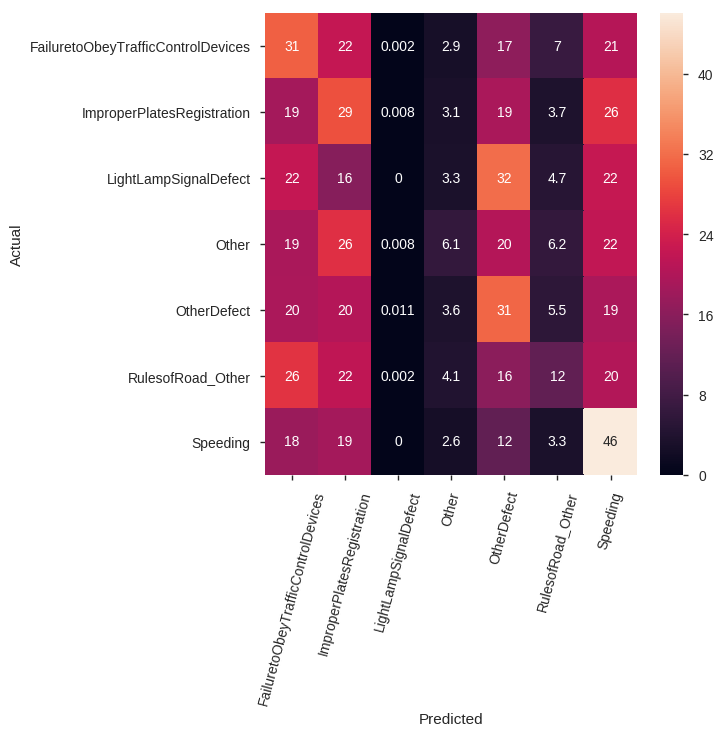

In [12]:
# Run for Naive Bayes
display(Markdown('## Naive Bayes Metrics'))
nb_mdl_predicted = evaluate_model(nb_mdl)

## Logistic Regression Metrics

Accuracy Score: 25.07%


### Confusion Matrix

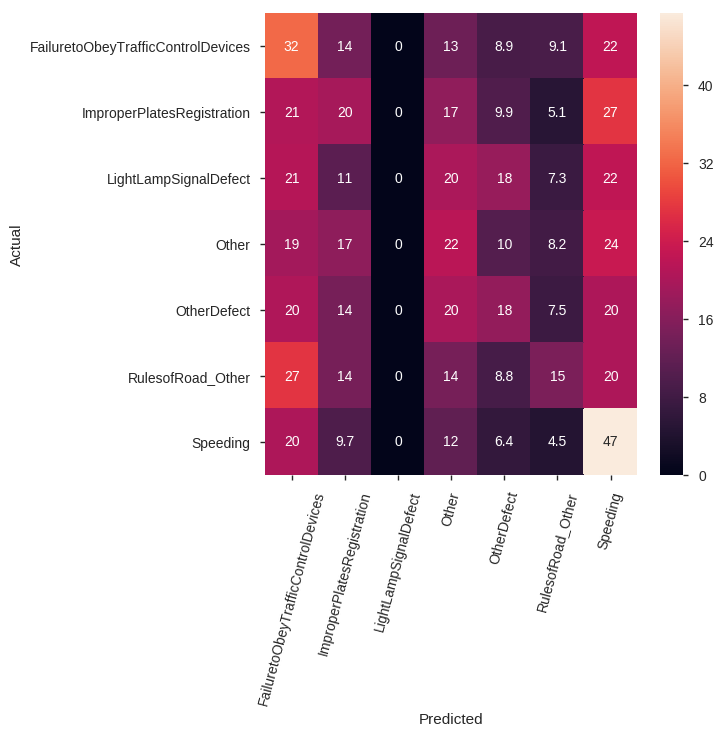

In [13]:
# Run for Logistic Regression
display(Markdown('## Logistic Regression Metrics'))
logistic_mdl_predicted = evaluate_model(logistic_mdl)

## Support Vector Machine Metrics

Accuracy Score: 25.85%


### Confusion Matrix

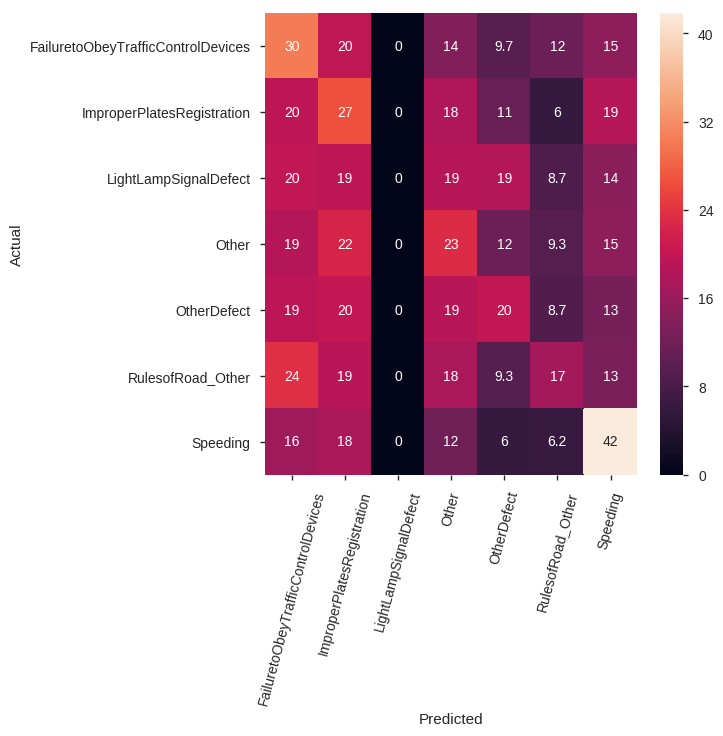

In [14]:
# Run for the Support Vector Machine
# Run for Naive Bayes
display(Markdown('## Support Vector Machine Metrics'))
svm_mdl_predicted = evaluate_model(svm_mdl)

## Random Forest Metrics

Accuracy Score: 44.98%


### Confusion Matrix

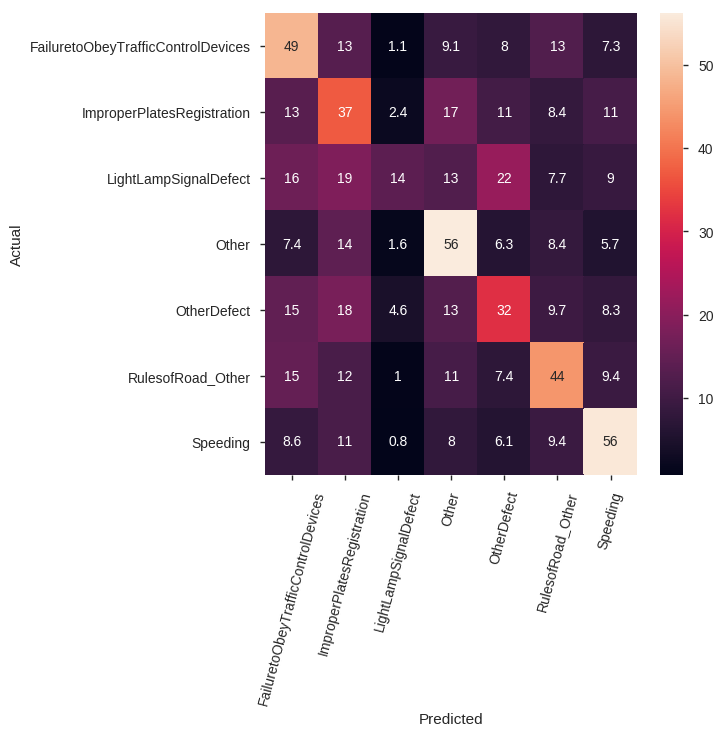

In [15]:
# Run for the Random Forest
display(Markdown('## Random Forest Metrics'))
rf_mdl_predicted = evaluate_model(rf_mdl)

## Random Forest with Entropy Metrics

Accuracy Score: 45.03%


### Confusion Matrix

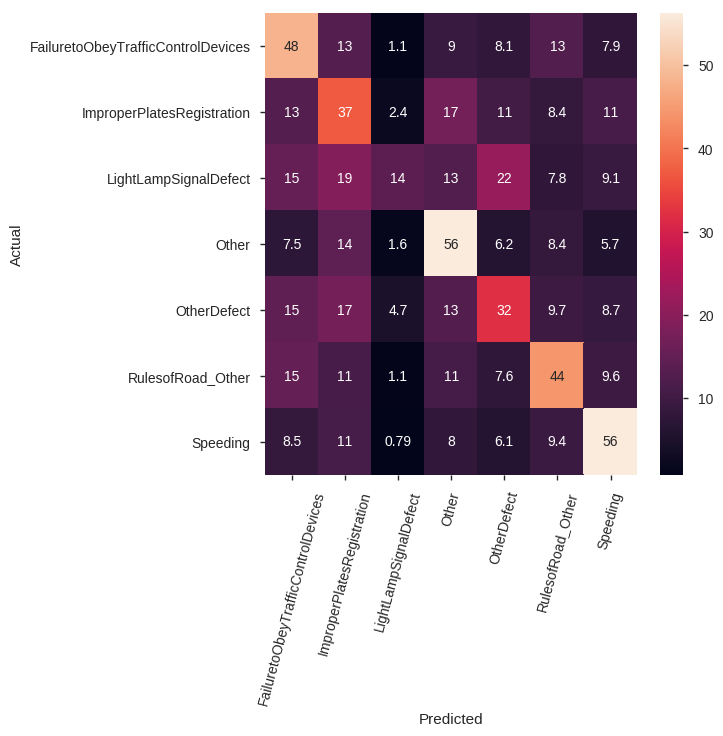

In [16]:
# Run for Random Forest with Entropy as the criterion
display(Markdown('## Random Forest with Entropy Metrics'))
rf_mdl_entropy_predicted = evaluate_model(rf_mdl_entropy)

## Summary
We observe a range of accuracies, going from the worst (Naive Bayes) with 24.69% accuracy, to our best (Random Forest with Entropy) at an accuracy of 45.03%.  Interestingly, both the logistic regression and support vector machine classifiers didn't identify any samples as having a LightLampSignalDefect charge, and even our best classifier only identified 14% of these charges made.  If we examine what these were identified as, a large part (22%) were identified with OtherDefect -- one way to improve the accuracy of these models would be to try and not be so ambitious and clump all defect charges together.  This would bring this combined charge to have an accuracy above the 32% that the OtherDefect charge currently has (with the random forest entropy classifier).

Other than that, we see that, with our best classifier, we get over half of the charges made in Speeding and Other correct.

# <font color="blue">Time on Tasks</font>
It is hard say exactly how much time I spent on the different tasks (as I wasn't tracking that), but as a very rough guess, we have:


| Task | Time (hours) | Notes |
| :--- | ---: | :---: |
| Data Retrieval | 8 | This includes time trying to select a problem/ searching through different data sets to see what to use.  Raw data retrieval, once I've identified what we want (including searching for the astral package to calculate daylight status) was probably closer to about an hour |
| Data Preparation & Exploration |  30 | I really don't know, but this made up all of Milestone 1 and a good chunk of Milestone 2.  This doesn't include all the time that Kyle and Tsun would have spent in their part of the data cleaning |
| Feature Selection & Engineering | 2 | Much of the feature engineering was done as a part of the preparation/ cleanup phase, with this being more of the time spent for the parts toward the end of Milestone 2 (just the feature selection part) |
| Data Modeling & Evaluation | 2 | This makes up the end of Milestone 2 and some of this Milestone.  Truthfully, I could have done more hyperparameter tuning, etc, but for the sake of time, this is what I have. |
| Deriving Insight |  2-3 | Most of my time in this is intermixed with the data preparation/ exploration phase. |